#### Library ##

Pyhton version of MATLAB code  https://github.com/hanyoseob/matlab-DMD

In [1]:
import xarray as xr
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pooch
import pandas as pd
from scipy import interpolate
import math
from mpmath import *
from mpl_toolkits import mplot3d

#### create an artificial signal composed of two basic signals

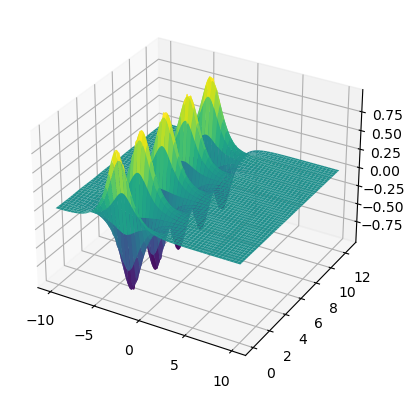

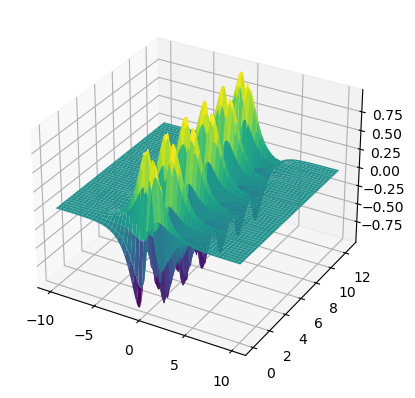

In [2]:
xi = np.linspace(-10,10,400)
t  = np.linspace(0,4*np.pi,200)

dt = t[1]-t[0]

[xgrid,tgrid] = np.meshgrid(xi,t)

f1 = (1/np.cosh(xgrid + 3))* (1*np.exp(1j*2.3*tgrid));
f2 = (1/np.cosh(xgrid))*np.tanh(xgrid)*(2*np.exp(1j*2.8*tgrid));

ax = plt.axes(projection='3d')
ax.plot_surface(xgrid,tgrid,np.real(f1),cmap='viridis')
plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(xgrid,tgrid,np.real(f2),cmap='viridis')

### SVD 

In [3]:
f        = f1 + f2
u, s, vt = np.linalg.svd(f.T)
s        = np.diag(s)
v        = vt.T

/Users/panini/opt/anaconda3/envs/jgrjdm/lib/python3.10/site-packages/numpy/ma/core.py:2826: ComplexWarning: Casting complex values to real discards the imaginary part
  _data = np.array(data, dtype=dtype, copy=copy,


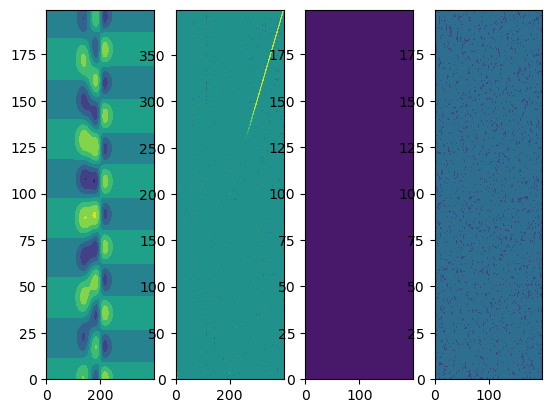

In [4]:
fig = plt.figure()
ax1 = fig.add_subplot(1,4,1)
ax1.contourf(f)
ax2 = fig.add_subplot(1,4,2)
ax2.contourf(u)
ax3 = fig.add_subplot(1,4,3)
ax3.contourf(s)
ax4 = fig.add_subplot(1,4,4)
ax4.contourf(v)


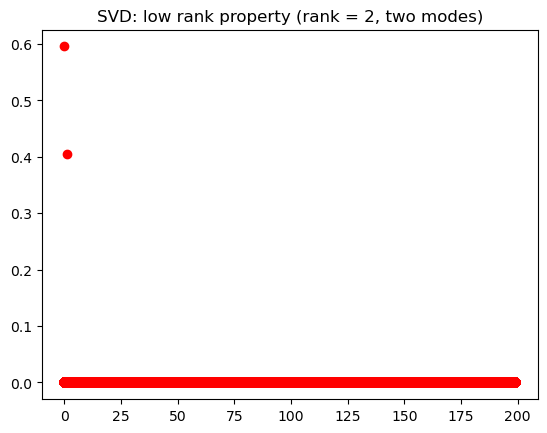

In [5]:
plt.plot(s / np.sum(s), 'ro');
plt.title('SVD: low rank property (rank = 2, two modes)');

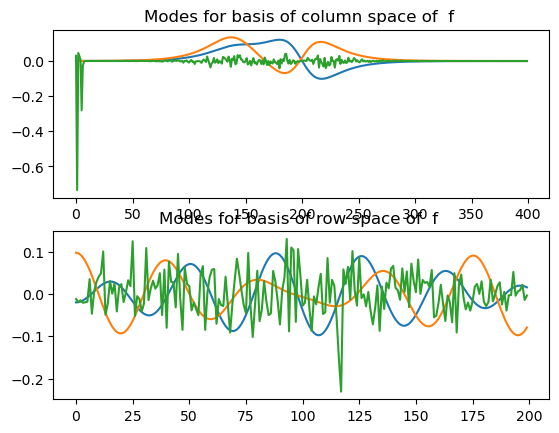

In [6]:
fig=plt.figure()
ax1 =fig.add_subplot(2,1,1); 
ax1.plot(np.real(u[:, :3])); 
ax1.set_title('Modes for basis of column space of '' f ''');

ax2=fig.add_subplot(2,1,2); 
ax2.plot(np.real(v[:, :3]));

ax2.set_title('Modes for basis of row space of '' f ''');


### Dynamical Mode Decomposition (DMD) ###

/var/folders/w6/twt25wq11ddfx5b267xt2pbh0000gn/T/ipykernel_17006/1471742126.py:51: ComplexWarning: Casting complex values to real discards the imaginary part
  t_dyn[:, i] = b*np.exp(omega*t[i]);


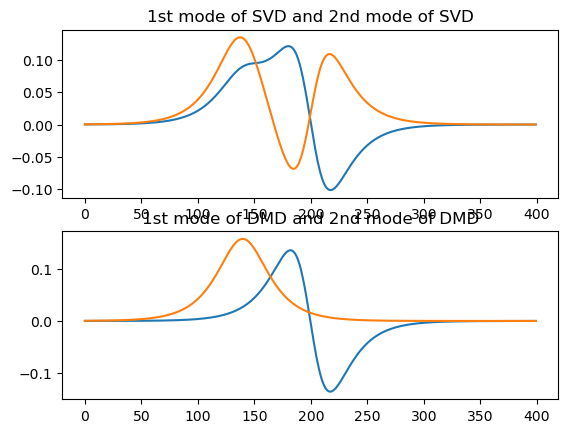

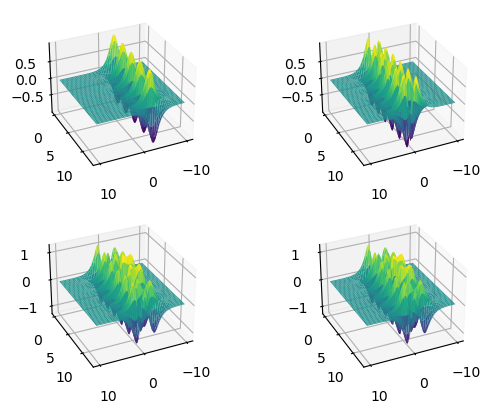

In [101]:
X       = f.T

X1      = X[:,:-1]
X2      = X[:, 1:]

###%% STEP 1: singular value decomposition (SVD)

r        = 2;      #% rank-r truncation
U, S, Vt = np.linalg.svd(X1);
V        = Vt.T


Ur       = U[:, :r]
Sr       = np.diag(S[:r])
Vr       = np.conj(V[:,:r])

##%% STEP 2: low-rank subspace matrix 
##%         (similarity transform, least-square fit matrix, low-rank subspace matrix)
Atilde   = Ur.T@X2@Vr@np.linalg.inv(Sr)


#%% STEP 3: eigen decomposition
#% W: eigen vectors
#% D: eigen values
D, W    = np.linalg.eig(Atilde)


## %% STEP 4: real space DMD mode

phi     = X2@Vr@np.linalg.inv(Sr)@W

lambda1 = D
omega   = np.log(lambda1)/dt

fig     = plt.figure()

ax1     = fig.add_subplot(2,1,1)
ax1.plot(np.real(u[:, :2]))
ax1.set_title('1st mode of SVD and 2nd mode of SVD')
ax2=fig.add_subplot(2,1,2); ax2.plot(np.real(phi))
ax2.set_title('1st mode of DMD and 2nd mode of DMD')


##% STEP 5: reconstruct the signal
x1 = X[:, 0];       #% time = 0
b = np.linalg.pinv(phi)@x1;   #% initial value; \: pseudo inverse

t_dyn = np.zeros((r, len(t)));

for i in range(len(t)):
   t_dyn[:, i] = b*np.exp(omega*t[i]); 

f_dmd = phi@t_dyn;


fig=plt.figure();
ax1=fig.add_subplot(2,2,1,projection='3d'); ax1.plot_surface(xgrid, tgrid, np.real(f1),cmap='viridis');
ax2=fig.add_subplot(2,2,2,projection='3d'); ax2.plot_surface(xgrid, tgrid, np.real(f2),cmap='viridis');  
ax3=fig.add_subplot(2,2,3,projection='3d'); ax3.plot_surface(xgrid, tgrid, np.real(f),cmap='viridis');  
ax4=fig.add_subplot(2,2,4,projection='3d'); ax4.plot_surface(xgrid, tgrid, np.real(f_dmd).T,cmap='viridis');
ax1.view_init(30,65)
ax2.view_init(30,65)
ax3.view_init(30,65)
ax4.view_init(30,65)



#### Future Prediction

/var/folders/w6/twt25wq11ddfx5b267xt2pbh0000gn/T/ipykernel_17006/567161295.py:11: ComplexWarning: Casting complex values to real discards the imaginary part
  t_ext_dyn[:, i] = b*np.exp(omega*t_ext[i]);


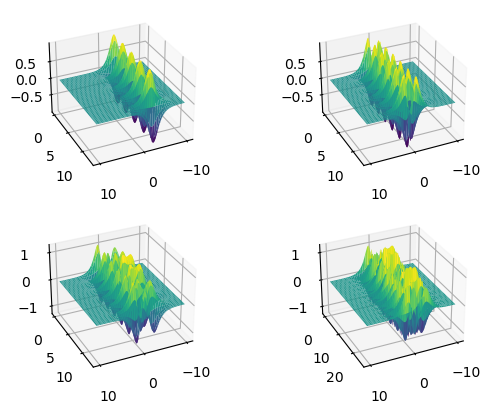

In [102]:

##%% additional informations
##% predict furture state using time dynamics

t_ext = np.linspace(0, 8*np.pi, 400)

[xgrid_ext, tgrid_ext] = np.meshgrid(xi, t_ext)

t_ext_dyn = np.zeros((r, len(t_ext)));

for i in range(len(t_ext)):
   t_ext_dyn[:, i] = b*np.exp(omega*t_ext[i]); 

f_dmd_ext = phi@t_ext_dyn

fig=plt.figure();
ax1=fig.add_subplot(2,2,1,projection='3d'); ax1.plot_surface(xgrid, tgrid, np.real(f1),cmap='viridis');
ax2=fig.add_subplot(2,2,2,projection='3d'); ax2.plot_surface(xgrid, tgrid, np.real(f2),cmap='viridis');  
ax3=fig.add_subplot(2,2,3,projection='3d'); ax3.plot_surface(xgrid, tgrid, np.real(f),cmap='viridis');  
ax4=fig.add_subplot(2,2,4,projection='3d'); ax4.plot_surface(xgrid_ext, tgrid_ext, np.real(f_dmd_ext).T,cmap='viridis');

ax1.view_init(30,65)
ax2.view_init(30,65)
ax3.view_init(30,65)
ax4.view_init(30,65)


# % If eigen value: lambda or omega has tiny real part > 0,
# % the output of system function which is spaned 
# % by eigen vectors with eigen values goes to the infinity.
# % It is one of the limitation of DMD method.